In [2]:
# This code serves as a guide for replication and further development of PINNs, consequently its hevily commented and explained.
# This code stems from various sources, along the code it will be commented in detail and the sources from which the code stems or is used will be listed
# I was heavily directed by Kaggle´s Neural Network Structure due to their courses on Machine Learning and to implementation of PINNs in https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_PIKANs_DeepONets/blob/main/Tutorials/PINNs/2_SimpleODE.ipynb
# therefore many parts of the code will be equal or analogous to their structure and notation of the construction of Neural Networks
# which tend to be a standard form of model construction, this will be marked as (Standard). This code uses other sources or open code and
# it will be explained along the code, finally, artificial intelligence has been used for debugging and optimization of the performace of the code.


# Import of important libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import activations

# (Standard)
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


In [3]:
# Definition of the parameters m and k of the system

m = 1.0
k = 1.0
t = np.linspace(0, 10, 100).reshape(-1, 1)

# Definition of PINN (Standard) and https://keras.io/2/api/models/model/
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__() #call __init__ from parent class

        # forms used in (Standard)
        self.denses = [Dense(120, activation=activations.tanh) for i in range(3)]
        self.outer = Dense(1, activation=None)

    def call(self, t):
        x = t
        for dense in self.denses:
            x = dense(x)
        return self.outer(x)



In [4]:

# Loss function definition
def loss_function(model, t):

    t = tf.Variable(t, dtype=tf.float32)
    # https://medium.com/@telega.slawomir.ai/automatic-differentiation-in-tensorflow-a-practical-example-b557b27b330b
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape() as tape1:
            tape1.watch(t)
            x = model(t)
            dx_dt = tape1.gradient(x, t)

        tape2.watch(dx_dt)
        d2x_dt2 = tape2.gradient(dx_dt, t)

    # Differential equation to minimize
    eq = m * d2x_dt2 + k * x
    loss_PDE = tf.reduce_mean(tf.square(eq))

    # Boundary difference loss
    with tf.GradientTape(persistent=True) as tape1:

        t = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
        tape1.watch(t)
        x0_pred = model(t)
        dx0_pred = tape1.gradient(x0_pred, t)

    #debug AI
    del tape1
    loss_ICx = tf.reduce_mean(tf.square(x0_pred - 1))
    loss_ICv = tf.reduce_mean(tf.square(dx0_pred - 0))

    # Total loss
    loss = loss_PDE + loss_ICx + loss_ICv
    return loss

# Model
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


In [6]:
# Testing and validating data (Standard)
train_t, val_t = train_test_split(t, random_state = 0)

In [7]:
# Training PINN

loss_values = []
loss_general = []
epochs = 5000


# Run of epochs https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=es-419
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_function(model, tf.convert_to_tensor(train_t, dtype=tf.float32))
        loss_values.append(loss_function(model, tf.convert_to_tensor(val_t, dtype=tf.float32)))
        loss_general.append(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")


Epoch 0, Loss: 1.0142744779586792
Epoch 500, Loss: 0.03047730214893818
Epoch 1000, Loss: 0.014667064882814884
Epoch 1500, Loss: 0.005954144522547722
Epoch 2000, Loss: 0.0001430045667802915
Epoch 2500, Loss: 0.0007629222236573696
Epoch 3000, Loss: 0.0009592780843377113
Epoch 3500, Loss: 0.00887000747025013
Epoch 4000, Loss: 0.00020951621991116554
Epoch 4500, Loss: 0.0003096969739999622


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


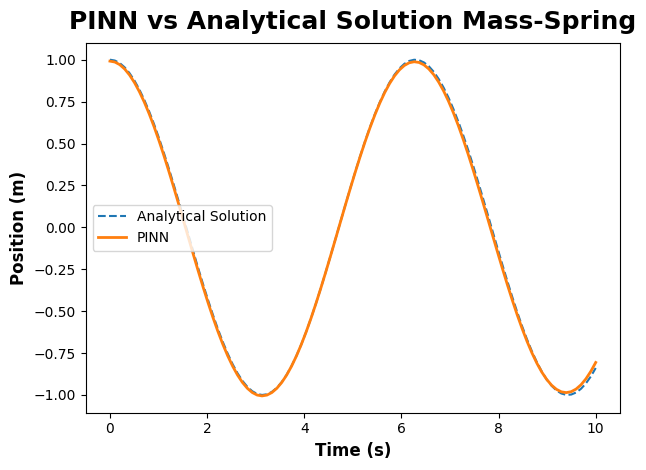

In [8]:
# Predict and compare
x_pred = model.predict(t)
x_true = np.cos(np.sqrt(k/m) * t)



plt.plot(t, x_true, label="Analytical Solution", linestyle="dashed")
plt.plot(t, x_pred, label="PINN", linewidth=2)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("PINN vs Analytical Solution Mass-Spring")
plt.show()

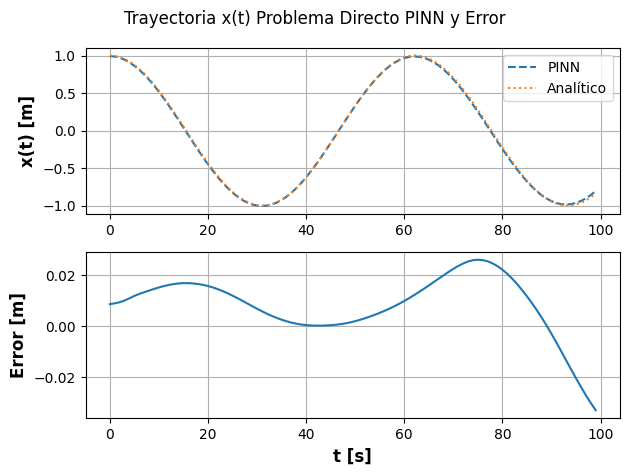

In [15]:
fig, axs = plt.subplots(2)
fig.suptitle('Trayectoria x(t) Problema Directo PINN y Error')

axs[0].plot(x_pred, label='PINN', linestyle='--')
axs[0].set( ylabel='x(t) [m]')
axs[0].grid(True)
axs[0].legend(loc='upper right', bbox_to_anchor=(1, 1))
axs[0].plot(np.cos(np.sqrt(k/m) * t)  , label='Analítico', linestyle='dotted')
axs[0].legend()


axs[1].plot(-x_pred + np.cos(np.sqrt(k/m) * t)  )
axs[1].set(xlabel='t [s]', ylabel='Error [m]')
axs[1].grid(True)